There are three validation checks we need to do on each hand combination that was passed into the previous array in order to evaluate if it's a legitimate hand or not:

1.  The hand level sum needs to be lower than the max value for the hand and level
    - This is done by assigning each card in the combination it's level, so a level 1 card gets a 1, level 2 a 2, etc.
    - The sum of the array's level values then needs to be lower than the max value given by the following formula:
        - Max value formula = ((([1] + [Level])*[Level])/2) + ([Hand Size] - [Level])
        - Ex: For the Brute class, when evaluating hand combinations at level 2's selection time:
            - (((1+2)*2)/2) + (10-2)
            - 3 + 8 = 11
        - Intuitively, this makes sense as at level 1, the Brute class would have 10 level 1 cards for a total of 10
        - At level 2, at most, you would select one level 2 card and replace a level 1 card with it
        - That would replace a 1 value with a 2, taking the max value possible up to 11
        - If we ever run into a class that has a hand size lower than 8, this formula will need to be tweaked
            - This is because at a hand size of 8, you could remove a level 1 card for each level up
            - At a hand size of 7 or lower, the top level ups would mean you need to replace a card value over 1
        
2. At the level being evaluated, each hand combination can only have one of the level cards
    - When leveling up, you can initially only select a single card for the given level
    - This will filter out any combinations that load in something like two level 2 cards when evaluating level 2
    
3. The amount of cards over level 1 in the hand cannot exceed then evaluation level minus 1
    - This is because you can only make one card selection every time you level up
    - It is allowed for you to take a card lower than the level you're on, for example taking the 2nd lvl 2 card at level 3's promotion rather than a level 3
    - You cannot though have something like both level 2 cards AND a level 3 card at level 3
    - As the levels get higher, there are ways to make summation combinations that fall meet conditions 1 and 2 but use more cards > level 1 than is permitted

In [116]:
# Importing packages
import numpy as np
import pandas as pd
import itertools
import statistics as stat
import time
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Loading in CSV data
rawdata = pd.read_csv("GloomhavenTest.csv")
gen_classinfo = pd.read_csv("ClassInfo.csv")

In [3]:
# Creating a max value function that will evaluate the value for condition 1 above
def maxvalue(handsize, current_level):
    return (((1 + current_level)*current_level)/2) + (handsize - current_level)

# Creating a function to count the number of cards at a level in a list
def lvl_counter(input_list, value):
    return sum([1 for v in input_list if v == value])

In [8]:
# %%timeit

# Creating dictionaries to hold results
class_dict = dict()
level_dict = dict()
count_result_dict = dict()
avg_result_dict = dict()
stdev_result_dict = dict()

loop_lvl = 9

for i in range(6):
    # Setting data items for use later in code
    active_class = gen_classinfo['Class'][i]       # Setting the active class (Class[0] = Brute)
    hand_size = gen_classinfo['Hand Size'][i]      # Setting the hand size
    

    for j in set(rawdata[(rawdata['Level'] <= loop_lvl)]['Level']):

        # Setting the level and initiative columns for values up to the current level
        current_level = j   # Current level for the loop (envisioning this as a 1 -> 9 loop later)
        level_df = rawdata[(rawdata['Class'] == active_class) & (rawdata['Level'] <= current_level)]['Level']
        initiative_df = rawdata[(rawdata['Class'] == active_class) & (rawdata['Level'] <= current_level)]['Initiative']
        currlvl_df = pd.concat([level_df, initiative_df], axis = 1)


        # Second swing at a different roll-up method, using evaluations steps while looping the comb. iterator
        max_value = maxvalue(hand_size, current_level)  # Setting the max value for this class/level
        curr_lvl_minus1 = (current_level - 1)

        # Creating a dictionary to assign a binary 1 or 0 to each combination, based on it passing the hand conditions
        level_comb2 = dict()
        dict_counter = 0

        for hand in itertools.combinations(currlvl_df['Level'], hand_size):
            if sum(hand) <= max_value and \
            (hand_size - lvl_counter(hand,1)) <= curr_lvl_minus1 and (lvl_counter(hand, current_level)) != 2:
                level_comb2[dict_counter] = True
            else:
                level_comb2[dict_counter] = False 
            dict_counter += 1


        # Now creating a dictionary to reference the above binary dictionary in order to populate hand averages for valid hands
        initiative_comb2 = dict()
        dict_counter = 0
        valid_dict_counter = 0

        for hand in itertools.combinations(currlvl_df['Initiative'], hand_size):
            if level_comb2[dict_counter]:
                initiative_comb2[valid_dict_counter] = (sum(hand)/hand_size)
                valid_dict_counter += 1
            dict_counter += 1

        initiative_comb2_df = pd.DataFrame.from_dict(initiative_comb2, orient = 'Index')

        # Writing results
        class_dict[(i*loop_lvl) + j - 1] = active_class
        level_dict[(i*loop_lvl) + j - 1] = current_level
        count_result_dict[(i*loop_lvl) + j - 1] = len(initiative_comb2_df)
        avg_result_dict[(i*loop_lvl) + j - 1] = initiative_comb2_df.mean()
        stdev_result_dict[(i*loop_lvl) + j - 1] = initiative_comb2_df.std()
        
        
# Writing results        
class_df = pd.DataFrame.from_dict(class_dict, orient = 'Index')
level_df = pd.DataFrame.from_dict(level_dict, orient = 'Index')
count_results_df = pd.DataFrame.from_dict(count_result_dict, orient = 'Index')
avg_results_df = pd.DataFrame.from_dict(avg_result_dict, orient = 'Index')
stdev_results_df = pd.DataFrame.from_dict(stdev_result_dict, orient = 'Index')

total_results_df = pd.concat([class_df, level_df, count_results_df, avg_results_df, stdev_results_df], axis = 1)
total_results_df.columns = ['Class', 'Level', 'Hand Count', 'Average', 'Std. Dev.']

print(total_results_df)

          Class  Level  Hand Count    Average  Std. Dev.
0         Brute      1         286  44.000000   3.995919
1         Brute      2        1716  43.416667   4.326364
2         Brute      3        9581  43.502985   4.564459
3         Brute      4       46618  44.301534   5.266695
4         Brute      5      200343  43.646467   5.377058
5         Brute      6      744458  43.036881   5.583827
6         Brute      7     2405689  42.133240   5.542226
7         Brute      8     6806371  41.007196   5.616149
8         Brute      9    17178772  41.295620   5.679533
9      Tinkerer      1         455  45.000000   3.057243
10     Tinkerer      2        3185  46.107143   3.498686
11     Tinkerer      3       20930  46.339130   3.957028
12     Tinkerer      4      120757  46.809030   4.552776
13     Tinkerer      5      619411  47.398916   4.735900
14     Tinkerer      6     2765997  47.885255   4.864349
15     Tinkerer      7    10765430  48.536790   5.348468
16     Tinkerer      8    36548

In [134]:
total_results_df = total_results_df.assign(L_StdDev = total_results_df['Average']-(total_results_df['Std. Dev.']*2))
total_results_df = total_results_df.assign(H_StdDev = total_results_df['Average']+(total_results_df['Std. Dev.']*2))

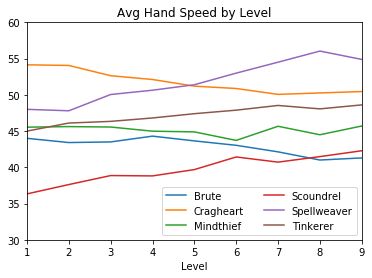

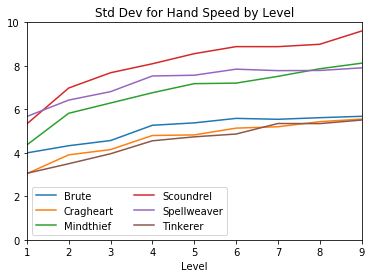

In [87]:
fig, ax = plt.subplots()

for key, grp in total_results_df.groupby(['Class']):
    ax = grp.plot(ax=ax,kind='line', x='Level', y='Average', label=key, title='Avg Hand Speed by Level')

plt.axis([1,9,30,60])
plt.legend(loc='best', ncol = 2)
plt.show()


fig,ax = plt.subplots()

for key, grp in total_results_df.groupby(['Class']):
    ax = grp.plot(ax=ax, kind='line', x='Level', y='Std. Dev.', label=key, title='Std Dev for Hand Speed by Level')

plt.axis([1,9,0,10])
plt.legend(loc='best', ncol = 2)
plt.show()

In [15]:
writer = pd.ExcelWriter('HandAvg_byLevel_output.xlsx')
total_results_df.to_excel(writer, 'Sheet1')
writer.save()

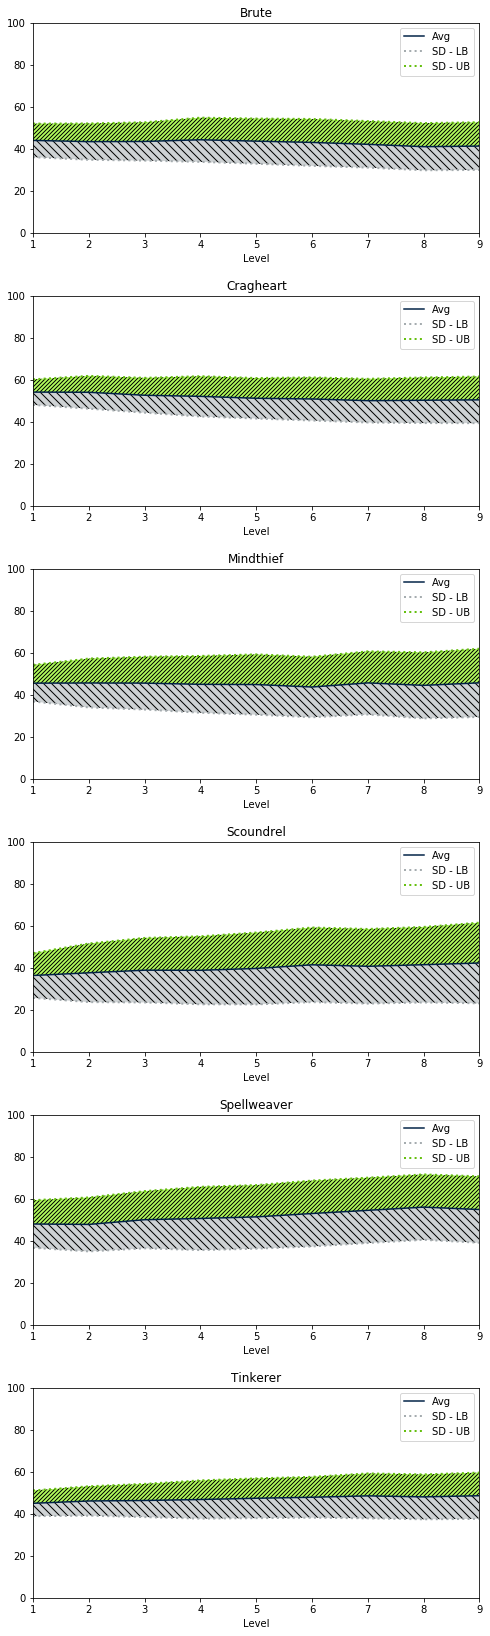

In [195]:
# row and column sharing
f, axarr = plt.subplots(6, figsize=(8,25))
i = 0

for key, grp in total_results_df.groupby(['Class']):
    x = grp['Level']
    y1 = grp['Average']
    y2 = grp['H_StdDev']
    y3 = grp['L_StdDev']
    
    axarr[i] = grp.plot(ax=axarr[i], kind='line', x='Level', y='Average', label='Avg', 
                        color='#002145')
    axarr[i] = grp.plot(ax=axarr[i], kind='line', x='Level', y='L_StdDev', label='SD - LB', 
                        linestyle=":", color='#A5ACAF', linewidth=2)
    axarr[i] = grp.plot(ax=axarr[i], kind='line', x='Level', y='H_StdDev', label='SD - UB', 
                        linestyle=":", color='#66C010', linewidth=2)
    axarr[i].set_title(key)
    axarr[i].axis([1,9,0,100])
    
    axarr[i].fill_between(x, y1, y2, where = (y2 > y1), facecolor='#B3FF5D', hatch=3*"//")
    axarr[i].fill_between(x, y1, y3, where = (y3 < y1), facecolor='#CED2D4', hatch=3*"\\")
    
    i += 1
        
plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=1, hspace=0.3)